# OPDI Hexaero 
Implementation of HexAero ID based on runway hexagonification.

In [1]:
import sys
sys.path.append('/home/cdsw/python/v2.0.0/')
from helperfunctions import *

In [2]:
import os
from IPython.display import display, HTML
# Get environment variables
engine_id = os.getenv('CDSW_ENGINE_ID')
domain = os.getenv('CDSW_DOMAIN')

# Format the URL
url = f"https://spark-{engine_id}.{domain}"

# Display the clickable URL
display(HTML(f'<a href="{url}">{url}</a>'))

In [3]:
# Regular imports
import pandas as pd 
import numpy as np
import time
import os
import shutil
from datetime import datetime
from openap.phase import FlightPhase
from IPython.display import display, HTML

# Spark imports
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.functions import avg, udf, abs, col, array_contains, avg, lag, when,  pandas_udf, PandasUDFType, lit, col, when, lag, lead, min, max, sum as Fsum, explode, array, monotonically_increasing_id, round
from pyspark.sql.types import DoubleType, StructType, StructField, IntegerType, StringType
from pyspark.sql.window import Window
from pyspark.sql import DataFrame, Window

from datetime import datetime, date
import dateutil.relativedelta
import calendar

# Hotfix
#!cp /runtime-addons/cmladdon-2.0.40-b150/log4j.properties /etc/spark/conf/

# Spark Session Initialization
#shutil.copy("/runtime-addons/cmladdon-2.0.40-b150/log4j.properties", "/etc/spark/conf/") # Setting logging properties
spark = SparkSession.builder \
    .appName("OPDI flight events and measurements ETL") \
    .config("spark.log.level", "ERROR")\
    .config("spark.ui.showConsoleProgress", "false")\
    .config("spark.hadoop.fs.azure.ext.cab.required.group", "eur-app-opdi") \
    .config("spark.kerberos.access.hadoopFileSystems", "abfs://storage-fs@cdpdllive.dfs.core.windows.net/data/project/opdi.db/unmanaged") \
    .config("spark.driver.cores", "1") \
    .config("spark.driver.memory", "5G") \
    .config("spark.executor.memory", "8G") \
    .config("spark.executor.cores", "1") \
    .config("spark.executor.instances", "2") \
    .config("spark.dynamicAllocation.maxExecutors", "15") \
    .config("spark.network.timeout", "800s")\
    .config("spark.executor.heartbeatInterval", "400s") \
    .config('spark.ui.showConsoleProgress', False) \
    .enableHiveSupport() \
    .getOrCreate()

# Database prep

# Settings
project = "project_opdi"
recreate_flight_event_table = False
recreate_measurement_table = False

## Range for processing
start_date = datetime.strptime('2022-01-01', '%Y-%m-%d')
end_date = datetime.strptime('2023-08-31', '%Y-%m-%d')


# Getting today's date
today = datetime.today().strftime('%d %B %Y')


Setting spark.hadoop.yarn.resourcemanager.principal to quinten.goens


## Transfer & filter OPDI runway hexagons

In [4]:
#query = """
#INSERT INTO project_aiu.opdi_runway_hexagons_bucketed_europe 
#SELECT
#    AIRPORT_IDENT,
#    LE_IDENT,
#    LE_HEADING_DEG,
#    HE_IDENT,
#    HE_HEADING_DEG,
#    HEX_ID,
#    HEX_RES,
#    HEX_LON,
#    HEX_LAT,
#    GATE_ID,
#    GATE_ID_NR
#FROM
#    project_aiu.opdi_runway_hexagons
#WHERE
#    HEX_LAT BETWEEN 26.74617 AND 70.25976
#    AND HEX_LON BETWEEN -25.86653 AND 49.65699;"""
#
#filtered_df = spark.sql(query)

## Create osn h3 osn statevector sample 7 days
Query irst 7 days of 2023, bucketed on icao24, callsign, event_time and h3_res_11.

In [5]:
#query = """
#INSERT INTO project_aiu.osn_h3_statevectors_bucket_sample 
#SELECT
#    *
#FROM
#    project_aiu.osn_h3_statevectors
#WHERE
#    EVENT_TIME BETWEEN 1672531201 AND 1673135999""" 
#
#filtered_df = spark.sql(query)

## Query testing sample function

def get_data_within_timeframe(spark, table_name, start_date, stop_date):
    """
    Retrieves records from a specified Spark table within the given timeframe.

    Args:
    spark (SparkSession): The SparkSession object.
    table_name (str): The name of the Spark table to query.
    start_date (str): The start date in 'YYYY-MM-DD' format.
    stop_date (str): The stop date in 'YYYY-MM-DD' format.

    Returns:
    pyspark.sql.dataframe.DataFrame: A DataFrame containing the records within the specified timeframe.
    """
    # Convert dates to POSIX time (seconds since epoch)
    start_posix = int(time.mktime(time.strptime(start_date, '%Y-%m-%d')))
    stop_posix = int(time.mktime(time.strptime(stop_date, '%Y-%m-%d')))

    # Load the table
    df = spark.table(table_name)

    # Filter records based on event_time column
    filtered_df = df.filter((col('event_time') >= start_posix) & (col('event_time') < stop_posix))

    return filtered_df

#sdf.write.format('parquet').save("abfs://storage-fs@cdpdllive.dfs.core.windows.net/data/project/aiu.db/unmanaged/day_osn_h3_statevectors1.parquet")

#sdf = spark.read.format('parquet').load("abfs://storage-fs@cdpdllive.dfs.core.windows.net/data/project/aiu.db/unmanaged/day_osn_h3_statevectors1.parquet")

## Create airport runway hexagonification spark dataset 

#### To do:
   * Upload airport_concentric_c_hex_res_6.arrow dataset to datalake.

def create_airport_coverage_set():
    df_apt = pd.read_parquet('../data/airport_hex/airport_concentric_c_hex_res_6.arrow')

    # Filter out relevant hexagons
    df_apt = df_apt[df_apt.max_c_radius_nm<=15]
    df_apt = df_apt[['ident','hex_id']].explode('hex_id')
    df_apt = df_apt[~df_apt.hex_id.isna()]

    # Getting h3 positions of hexagons 
    df_apt['geo'] = df_apt['hex_id'].apply(lambda l:h3.h3_to_geo(l))
    df_apt['lat'] = df_apt['geo'].apply(lambda l:l[0])
    df_apt['lon'] = df_apt['geo'].apply(lambda l:l[1])
    df_apt = df_apt.drop('geo',axis=1)

    # OSN bounding box filter
    f_lat = np.logical_and(df_apt.lat >=26.74617, df_apt.lat <= 70.25976)  
    f_lon = np.logical_and(df_apt.lon >=-25.86653, df_apt.lon <= 49.65699)  
    f = np.logical_and(f_lat, f_lon)
    df_apt = df_apt[f]

    # Renaming columns 
    df_apt.columns = ['apt_' + x for x in df_apt.columns]

    # Grouping by hex id
    df_apt = df_apt.groupby('apt_hex_id').agg(list)['apt_ident'].reset_index()

    # Creating spark df
    sdf_apt = spark.createDataFrame(df_apt)
    return sdf_apt

sdf_apt = create_airport_coverage_set()

## Applying hexagonification algorithm

### ~Helper function: Adding an ID to each statevector~

### Clean statevector data & filter out low altitude (<FL50)

In [6]:
from pyspark.sql.functions import col, array, lit, filter
month = datetime(2022,1,1)

flight_list = get_data_within_timeframe(
    spark, 
    'project_opdi.opdi_flight_list', 
    month, 
    time_col = 'dof', 
    unix_time = False).select(
    ['id', 'adep', 'ades']).withColumn(
    'apt', 
    filter(array(col("adep"), col("ades")), lambda x: x.isNotNull())).select(['id', 'apt'])

# Query data from datalake sample 

sv = get_data_within_timeframe( # State Vectors sv
    spark = spark, 
    table_name = 'project_opdi.osn_tracks_clustered', 
    month = month, 
    time_col = 'event_time',
    unix_time = True)

# Filter out rows with missing crucial data
sv_f = sv.dropna(subset=['lat', 'lon', 'baro_altitude'])

# Rename callsign to flight_id (official term)
sv_f = sv_f.withColumnRenamed("callsign", "flight_id")

# Replace missing 'flight_id' with empty string
sv_f = sv_f.fillna({'flight_id': ''})

# Convert event_time from posixtime to datetime 
sv_f = sv_f.withColumn('event_time', F.to_timestamp(F.col('event_time')))

# Add flight level extracted from baro_altitude
sv_f = sv_f.withColumn('altitude_ft', col('baro_altitude') * 3.28084)
sv_f = sv_f.withColumn('flight_level', col('altitude_ft') / 100)

# Select columns of interest
columns_of_interest = [
    'track_id', 'icao24', 'flight_id', 'event_time', 'lat', 'lon',  'altitude_ft', 'flight_level',
    'heading', 'vert_rate',  'on_ground', 'h3_res_6', 'h3_res_11'
]
sv_f = sv_f.select(columns_of_interest)

# Filter out low altitude statevectors 
sv_low_alt = sv_f.filter(col('flight_level') <= 50).cache()

# Merge with defined airports from flight_list

sv_nearby_apt = sv_low_alt.join(flight_list, sv.track_id == flight_list.id, how="inner")

## Load runway spark dataframe (rwy_sdf) 
rwy_sdf = spark.table('project_opdi.opdi_runway_hexagons_bucketed_europe')
rwy_cols_of_interest = [
    'airport_ident', 
    'le_ident', 
    'le_heading_deg', 
    'he_ident', 
    'he_heading_deg',
    'hex_id', 
    'gate_id', 
    'gate_id_nr'] 
rwy_sdf = rwy_sdf.select(rwy_cols_of_interest)

# Using the apt_ident provided by the first 'airport merge' speeds up the merge dramatically
sv_on_rwy = sv_nearby_apt.join(
    rwy_sdf, 
    (sv_nearby_apt.h3_res_11 == rwy_sdf.hex_id) & 
    array_contains(sv_nearby_apt.apt, rwy_sdf.airport_ident), 
    "inner")

Hive Session ID = 17857cc3-1d27-488a-b992-801642fda556


### Second narrowing down: Runway merge

### Assign new track_id
Currently the track_id is the icao24 and flight_id concatenated. However, multiple flights with the same icao24 and flight_id can happen. Here we split up tracks when there's subsequent statevectors separated by at least 40 minutes.

# Define a window spec partitioned by 'id' and ordered by 'time'
windowSpec = Window.partitionBy("track_id").orderBy("event_time")

# Calculate the time difference between consecutive rows
sv_on_rwy = sv_on_rwy.withColumn("time_diff", F.col("event_time").cast("long") - F.lag("event_time", 1).over(windowSpec).cast("long"))

# Flag rows where the time difference exceeds 40 minutes (40*60 seconds)
sv_on_rwy = sv_on_rwy.withColumn("new_flight_flag", F.when(F.col("time_diff") > 60*40, 1).otherwise(0))

# Cumulative sum of flags to create a sub-id
sv_on_rwy = sv_on_rwy.withColumn("sub_id", F.sum("new_flight_flag").over(windowSpec.rowsBetween(Window.unboundedPreceding, 0)))

# Concatenate original 'id' with 'sub_id' to form a new unique 'id'
sv_on_rwy = sv_on_rwy.withColumn(
    "track_id", 
    F.concat_ws("_", F.trim(F.col("track_id")), F.col("sub_id").cast("string"))
)

# Drop redundant columns to clean up
sv_on_rwy = sv_on_rwy.drop(*['time_diff', 'new_flight_flag', 'sub_id'])

### Split gate_id into multiple variables

* `gate_type`: Indicates the type of gate (runway_hexagons - rwy, low_numbered_approach_hexagons - le, high_numbered_approach_hexagons - he). 
* `gate_distance_from_rwy_nm`: Indicates the distance from the runway le/he center. 

In [7]:
sv_on_rwy = sv_on_rwy.withColumn(
    "gate_type", 
    when(
        col("gate_id") == "runway_hexagons", "runway_hexagons"
    ).otherwise(
        concat_ws(
            "_", 
            split(col("gate_id"), "_").getItem(0),
            split(col("gate_id"), "_").getItem(1),
            split(col("gate_id"), "_").getItem(2),
            split(col("gate_id"), "_").getItem(3)
        )
    )
).withColumn(
    "gate_distance_from_rwy_nm",
    when(
        col("gate_id") == "runway_hexagons", 0
    ).otherwise(
        split(col("gate_id"), "_").getItem(4).cast("int")
    )
)


# Rename the values in the 'gate_type' column
sv_on_rwy = sv_on_rwy.withColumn(
    "gate_type",
    when(sv_on_rwy["gate_type"] == "high_numbered_approach_hexagons", "hex_he")
    .when(sv_on_rwy["gate_type"] == "runway_hexagons", "hex_rwy")
    .when(sv_on_rwy["gate_type"] == "low_numbered_approach_hexagons", "hex_le")
    .otherwise(sv_on_rwy["gate_type"])
)

NameError: name 'concat_ws' is not defined

### Collect heuristics for later analysis

To determine whether an aircraft lands or takes-off on a certain runway successfully we need well defined heuristics. For HexAero the following heuristics are determined for later analysis:
* `min_gate_distance`: The minimum distance a track_id reaches to a certain le/he runway.
* `max_gate_distance`: The maximum distance a track_id reaches to a certain le/he runway.
time_entry_min_gate_distance
flight_lvl_min_gate_distance
heading_min_gate_distance
time_entry_max_gate_distance
flight_lvl_max_gate_distance
heading_max_gate_distance

In [ ]:
# Filter down to necessary elements
cols_of_interest = [
    'track_id', 
    'icao24', 
    'flight_id', 
    'event_time', 
    'flight_level', 
    'heading',
    'airport_ident',
    'le_ident',
    'le_heading_deg', 
    'he_ident', 
    'he_heading_deg', 
    'gate_id',
    'gate_id_nr', 
    'gate_type', 
    'gate_distance_from_rwy_nm'] 

sv_on_rwy = sv_on_rwy.select(cols_of_interest)

# Create a copy of the DataFrame
sv_on_rwy_cp = sv_on_rwy.cache()  # Using cache to optimize as the data is used multiple times

# Group the data and compute the minimum and maximum 'gate_distance_from_rwy_nm' for each group
# Define the window specification based on the grouping
partition_cols = [
    "track_id", "icao24", "flight_id", "airport_ident", 
    "le_ident", "le_heading_deg", "he_ident", "he_heading_deg", "gate_type"]

windowSpec = Window.partitionBy(partition_cols)

# Get the intersections per landing/take-off 
# Create a DataFrame with unique gate_id counts per group
unique_counts = (
    sv_on_rwy_cp
    .groupBy(partition_cols + ["gate_id"])  # Group by partition columns and gate_id
    .agg(F.count("gate_id").alias("count"),  # Count occurrences of gate_id
         F.first("gate_distance_from_rwy_nm").alias("gate_distance_from_rwy_nm"))  # Collect gate_ids into a list
    .groupBy(partition_cols)  # Group again by partition columns
    .agg(
        F.count("count").alias("intersected_subsections_count"),  # Sum up all the counts
        F.collect_set("gate_distance_from_rwy_nm").alias("intersected_subsections_list")  # Collect lists of gate_ids
    )
)


# Join this back to the original DataFrame to distribute the unique counts to all rows
sv_on_rwy_cp = sv_on_rwy_cp.join(
    unique_counts,
    on=partition_cols,
    how="left"
)

# Calculate the minimum and maximum gate distances from the runway for each group
sv_on_rwy_cp = sv_on_rwy_cp.withColumn(
    "min_gate_distance",
    F.min("gate_distance_from_rwy_nm").over(windowSpec)
).withColumn(
    "max_gate_distance",
    F.max("gate_distance_from_rwy_nm").over(windowSpec)
)

# Filter to ensure only rows with the minimum or maximum gate distances are retained
min_dist = sv_on_rwy_cp.filter(
    (F.col("gate_distance_from_rwy_nm") == F.col("min_gate_distance"))
)

max_dist = sv_on_rwy_cp.filter(
    (F.col("gate_distance_from_rwy_nm") == F.col("max_gate_distance"))
)

# Define the columns to group by
cols_to_group = [
    "track_id", "icao24", "flight_id", "airport_ident", "le_ident", 
    "le_heading_deg", "he_ident", "he_heading_deg", "gate_type",
    "min_gate_distance", "max_gate_distance", "intersected_subsections_list", "intersected_subsections_count"
]

# Group by and aggregate min_dist
min_dist_agg = min_dist.groupBy(cols_to_group).agg(
    F.min("event_time").alias("time_entry_min_gate_distance"),
    F.expr("percentile_approx(flight_level, 0.5)").alias("flight_lvl_min_gate_distance"),
    F.expr("percentile_approx(heading, 0.5)").alias("heading_min_gate_distance")
)

# Group by and aggregate max_dist
max_dist_agg = max_dist.groupBy(cols_to_group).agg(
    F.min("event_time").alias("time_entry_max_gate_distance"),
    F.expr("percentile_approx(flight_level, 0.5)").alias("flight_lvl_max_gate_distance"),
    F.expr("percentile_approx(heading, 0.5)").alias("heading_max_gate_distance")
)

# Merge min_dist_agg and max_dist_agg on cols_to_group using an outer join
heuristics_df = min_dist_agg.join(
    max_dist_agg,
    on=cols_to_group, 
    how='outer'
)

# Define the specific gate types
gate_types = ["hex_le", "hex_he", "hex_rwy"]  # Replace with actual gate type values

# Final pivot to organize by 'gate_type'
heuristics_df = heuristics_df.groupBy(
    "track_id", "icao24", "flight_id", "airport_ident",
    "le_ident", "le_heading_deg", "he_ident", "he_heading_deg"
).pivot("gate_type", gate_types).agg(
    F.first("time_entry_min_gate_distance").alias("time_entry_min"),
    F.first("flight_lvl_min_gate_distance").alias("flight_level_min"),
    F.first("heading_min_gate_distance").alias("heading_min"),
    F.first("time_entry_max_gate_distance").alias("time_entry_max"),
    F.first("flight_lvl_max_gate_distance").alias("flight_level_max"),
    F.first("heading_max_gate_distance").alias("heading_max"),
    F.first("min_gate_distance").alias("min_gate_distance"),
    F.first("max_gate_distance").alias("max_gate_distance"),
    F.first("intersected_subsections_list").alias("intersected_subsections_list"),
    F.first("intersected_subsections_count").alias("intersected_subsections_count"),
)

heuristics_pdf = heuristics_df.toPandas()

In [13]:
# Determining the time (in seconds) since minimum distance of rwy for departure (d) or arrival (a) for le / he 

heuristics_pdf['da_he_time_since_min_dist_s'] = (
    heuristics_pdf['hex_he_time_entry_min'] - heuristics_pdf['hex_he_time_entry_max']).dt.total_seconds()

heuristics_pdf['da_he_flight_level_change_since_min_dist'] = (
    heuristics_pdf['hex_he_flight_level_min'] - heuristics_pdf['hex_he_flight_level_max']) 

#time_since_min_dist_s > 0 -> arrival
#time_since_min_dist_s < 0 -> departure

#FL_change_since_min_dist < 0 -> departure
#FL_change_since_min_dist < 0 -> arrival

def determine_da(time_since_min_dist_s, FL_change_since_min_dist):
    if pd.isnull(time_since_min_dist_s):
        time_since_min_dist_s = 0
    if pd.isnull(FL_change_since_min_dist):
        FL_change_since_min_dist = 0
    if ((time_since_min_dist_s > 0) & (FL_change_since_min_dist < 0)):
        return 'arrival'
    if ((time_since_min_dist_s < 0) & (FL_change_since_min_dist < 0)):
        return 'departure'
    if ((time_since_min_dist_s == 0) & (FL_change_since_min_dist < 0)):
        return 'arrival'
    if ((time_since_min_dist_s == 0) & (FL_change_since_min_dist > 0)):
        return 'departure'
    if ((time_since_min_dist_s > 0) & (FL_change_since_min_dist == 0)):
        return 'arrival'
    if ((time_since_min_dist_s < 0) & (FL_change_since_min_dist == 0)):
        return 'departure'
    if ((time_since_min_dist_s == 0) & (FL_change_since_min_dist == 0)):
        return None
    #print(time_since_min_dist_s, FL_change_since_min_dist)
    return 'undetermined'

heuristics_pdf['hex_he_status'] = heuristics_pdf.apply(lambda l: determine_da(l['da_he_time_since_min_dist_s'], l['da_he_flight_level_change_since_min_dist']),axis=1)

In [14]:
heuristics_pdf['da_le_time_since_min_dist_s'] = (
    heuristics_pdf['hex_le_time_entry_min'] - heuristics_pdf['hex_le_time_entry_max']).dt.total_seconds()

heuristics_pdf['da_le_flight_level_change_since_min_dist'] = (
    heuristics_pdf['hex_le_flight_level_min'] - heuristics_pdf['hex_le_flight_level_max']) 

heuristics_pdf['hex_le_status'] = heuristics_pdf.apply(lambda l: determine_da(l['da_le_time_since_min_dist_s'], l['da_le_flight_level_change_since_min_dist']),axis=1)

import plotly.express as px

px.density_contour(heuristics_pdf, x='da_he_time_since_min_dist_s', y = 'da_he_flight_level_change_since_min_dist', color = 'status')

In [15]:
# Calculating heuristics (hr_) for runways (rwy), low numbered (le) and high numbered (he) approach cones

## Number of intersections heuristics

heuristics_pdf['hr_rwy_detection'] = heuristics_pdf['hex_rwy_intersected_subsections_count'] >= 1

heuristics_pdf['hr_he_high_detection'] = heuristics_pdf['hex_he_intersected_subsections_count'] / 10 # Max 10 subsections
heuristics_pdf['hr_le_high_detection'] = heuristics_pdf['hex_le_intersected_subsections_count'] / 10 # Max 10 subsections



In [16]:

# Close approach to runway heuristic
heuristics_pdf['hr_he_touch_rwy'] = heuristics_pdf['hex_he_intersected_subsections_list'].fillna(0).apply(lambda l:np.sum(np.array(l)/10)/5.5)
heuristics_pdf['hr_le_touch_rwy'] = heuristics_pdf['hex_le_intersected_subsections_list'].fillna(0).apply(lambda l:np.sum(np.array(l)/10)/5.5)


In [17]:
# Heading alligned 

heuristics_pdf['hr_he_heading_alligned'] = abs(heuristics_pdf['hex_he_heading_min'] - heuristics_pdf['he_heading_deg']) < 30 
heuristics_pdf['hr_le_heading_alligned'] = abs(heuristics_pdf['hex_le_heading_min'] - heuristics_pdf['le_heading_deg']) < 30

heuristics_pdf['hr_he_heading_alligned_on_rwy'] = abs(heuristics_pdf['hex_rwy_heading_min'] - heuristics_pdf['he_heading_deg']) < 30 
heuristics_pdf['hr_le_heading_alligned_on_rwy'] = abs(heuristics_pdf['hex_rwy_heading_min'] - heuristics_pdf['le_heading_deg']) < 30



In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def heading_difference(deg1, deg2):
    """
    Calculate the minimum difference between two headings considering their cyclic nature.
    
    Parameters:
    deg1 (pd.Series): First series of headings in degrees.
    deg2 (pd.Series): Second series of headings in degrees.
    
    Returns:
    pd.Series: The minimum difference in degrees between the two headings.
    """
    difference = (deg1 - deg2 + 180) % 360 - 180
    # Adjust differences to be in the range -180 to 180
    difference = np.where(difference < -180, difference + 360, difference)
    return np.abs(difference)  # Return the absolute value of the difference

# Assuming 'heuristics_pdf' is your DataFrame
heuristics_pdf['he_heading_deviation_deg'] = heading_difference(
    heuristics_pdf['hex_he_heading_min'], 
    heuristics_pdf['he_heading_deg']
)

heuristics_pdf['le_heading_deviation_deg'] = heading_difference(
    heuristics_pdf['hex_le_heading_min'], 
    heuristics_pdf['le_heading_deg']
)

heuristics_pdf['he_heading_deviation_deg_on_rwy'] = heading_difference(
    heuristics_pdf['hex_rwy_heading_min'], 
    heuristics_pdf['he_heading_deg']
)

heuristics_pdf['le_heading_deviation_deg_on_rwy'] = heading_difference(
    heuristics_pdf['hex_rwy_heading_min'], 
    heuristics_pdf['le_heading_deg']
)

# Convert absolute deviation in degrees to a percentage of a full 360-degree circle
heuristics_pdf['hr_he_heading_allignment'] = (100 - (heuristics_pdf['he_heading_deviation_deg'] / 180) * 100)/100
heuristics_pdf['hr_le_heading_allignment'] = (100 - (heuristics_pdf['le_heading_deviation_deg'] / 180) * 100)/100

heuristics_pdf['hr_he_heading_allignement_on_rwy'] = (100 - (heuristics_pdf['he_heading_deviation_deg_on_rwy'] / 180) * 100)/100
heuristics_pdf['hr_le_heading_allignement_on_rwy'] = (100 - (heuristics_pdf['le_heading_deviation_deg_on_rwy'] / 180) * 100)/100

# Plotting the histogram of the heading deviations in percentage
plt.figure(figsize=(10, 6))
heuristics_pdf['le_heading_allignment_score'].hist(bins=30)
plt.title('Histogram of Heading Allignment as a Percentage')
plt.xlabel('Deviation (%)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plotting the histogram of the heading deviations in percentage
plt.figure(figsize=(10, 6))
heuristics_pdf['he_heading_allignment_score'].hist(bins=30)
plt.title('Histogram of Heading Allignment as a Percentage')
plt.xlabel('Deviation (%)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [19]:
# Calculate score
hr_rwy_detection_weight = 1
hr_section_detection_weight = 1
hr_touch_rwy_weight = 1
hr_heading_alligned_weight = 1
hr_heading_alligned_on_rwy_weight = 1

max_score = hr_rwy_detection_weight + hr_section_detection_weight + hr_touch_rwy_weight + hr_heading_alligned_weight + hr_heading_alligned_on_rwy_weight

heuristics_pdf['hr_he_score'] = (
                   heuristics_pdf['hr_rwy_detection'].fillna(0).apply(int)*hr_rwy_detection_weight + 
                   heuristics_pdf['hr_he_high_detection'].fillna(0).apply(float)*hr_section_detection_weight + 
                   heuristics_pdf['hr_he_touch_rwy'].fillna(0).apply(int)*hr_touch_rwy_weight + 
                   heuristics_pdf['hr_he_heading_allignment'].fillna(0).apply(float)*hr_heading_alligned_weight + 
                   heuristics_pdf['hr_he_heading_allignement_on_rwy'].fillna(0).apply(float)*hr_heading_alligned_on_rwy_weight
                  ) / max_score * 100

heuristics_pdf['hr_le_score'] = (
                   heuristics_pdf['hr_rwy_detection'].fillna(0).apply(int)*hr_rwy_detection_weight + 
                   heuristics_pdf['hr_le_high_detection'].fillna(0).apply(float)*hr_section_detection_weight + 
                   heuristics_pdf['hr_le_touch_rwy'].fillna(0).apply(int)*hr_touch_rwy_weight + 
                   heuristics_pdf['hr_le_heading_allignment'].fillna(0).apply(float)*hr_heading_alligned_weight + 
                   heuristics_pdf['hr_le_heading_allignement_on_rwy'].fillna(0).apply(float)*hr_heading_alligned_on_rwy_weight
                  ) / max_score * 100

In [20]:
heuristics_pdf['hr_he_gt_le'] = heuristics_pdf['hr_he_score'] > heuristics_pdf['hr_le_score']
heuristics_pdf['hr_he_le'] = heuristics_pdf['hr_he_gt_le'].replace(True, 'he').replace(False, 'le')
heuristics_pdf['hr_score'] = heuristics_pdf.apply(lambda l:l['hr_he_score'] if (l['hr_he_gt_le'] == True) else  l['hr_le_score'], axis=1)

In [21]:
cols = ['track_id', 'icao24', 'flight_id']

max_values = heuristics_pdf.groupby(cols)['hr_score'].transform(max)

# Filter the original DataFrame to get rows where the target column is equal to the max
max_rows = heuristics_pdf[heuristics_pdf['hr_score'] == max_values]

In [22]:
pd.set_option('display.max_columns', None)
max_rows[max_rows.track_id=='4bb1e4_THY4KX_0']

track_id  icao24 flight_id airport_ident le_ident  \
63477  4bb1e4_THY4KX_0  4bb1e4  THY4KX            LROP      08L   

       le_heading_deg he_ident  he_heading_deg hex_le_time_entry_min  \
63477            84.0      26R           264.0                   NaT   

       hex_le_flight_level_min  hex_le_heading_min hex_le_time_entry_max  \
63477                      NaN                 NaN                   NaT   

       hex_le_flight_level_max  hex_le_heading_max  hex_le_min_gate_distance  \
63477                      NaN                 NaN                       NaN   

       hex_le_max_gate_distance hex_le_intersected_subsections_list  \
63477                       NaN                                None   

       hex_le_intersected_subsections_count hex_he_time_entry_min  \
63477                                   NaN   2023-01-05 08:35:40   

       hex_he_flight_level_min  hex_he_heading_min hex_he_time_entry_max  \
63477                     13.0          265.088212   2023-01-05 08:36:15   

       hex_he_flight_level_max  hex_he_heading_max  hex_he_min_gate_distance  \
63477                     28.0          291.223657                       1.0   

       hex_he_max_gate_distance hex_he_intersected_subsections_list  \
63477                       3.0                           [1, 2, 3]   

       hex_he_intersected_subsections_count hex_rwy_time_entry_min  \
63477                                   3.0    2023-01-05 08:35:35   

       hex_rwy_flight_level_min  hex_rwy_heading_min hex_rwy_time_entry_max  \
63477                      11.0           264.882685    2023-01-05 08:35:35   

       hex_rwy_flight_level_max  hex_rwy_heading_max  \
63477                      11.0           264.882685   

       hex_rwy_min_gate_distance  hex_rwy_max_gate_distance  \
63477                        0.0                        0.0   

      hex_rwy_intersected_subsections_list  \
63477                                  [0]   

       hex_rwy_intersected_subsections_count  da_he_time_since_min_dist_s  \
63477                                    1.0                        -35.0   

       da_he_flight_level_change_since_min_dist hex_he_status  \
63477                                     -15.0     departure   

       da_le_time_since_min_dist_s  da_le_flight_level_change_since_min_dist  \
63477                          NaN                                       NaN   

      hex_le_status  hr_rwy_detection  hr_he_high_detection  \
63477          None              True                   0.3   

       hr_le_high_detection  hr_he_touch_rwy  hr_le_touch_rwy  \
63477                   NaN         0.109091              0.0   

       hr_he_heading_alligned  hr_le_heading_alligned  \
63477                    True                   False   

       hr_he_heading_alligned_on_rwy  hr_le_heading_alligned_on_rwy  \
63477                           True                          False   

       he_heading_deviation_deg  le_heading_deviation_deg  \
63477                  1.088212                       NaN   

       he_heading_deviation_deg_on_rwy  le_heading_deviation_deg_on_rwy  \
63477                         0.882685                       179.117315   

       hr_he_heading_allignment  hr_le_heading_allignment  \
63477                  0.993954                       NaN   

       hr_he_heading_allignement_on_rwy  hr_le_heading_allignement_on_rwy  \
63477                          0.995096                          0.004904   

       hr_he_score  hr_le_score  hr_he_gt_le hr_he_le   hr_score  
63477    65.781011    20.098076         True       he  65.781011

In [23]:
tmp = max_rows[['track_id', 'icao24', 'flight_id', 'airport_ident', 'hr_he_le', 'le_ident', 'he_ident', 'hr_score', 'hex_le_status', 'hex_le_time_entry_min', 'hex_he_time_entry_max']]

In [24]:
max_rows['hex_time_entry_min'] = max_rows['hex_le_time_entry_min'].fillna(max_rows['hex_he_time_entry_min']).fillna(max_rows['hex_he_time_entry_max']).fillna(max_rows['hex_le_time_entry_max'])
tmp = max_rows[['track_id', 'icao24', 'flight_id', 'airport_ident', 'hr_he_le', 'le_ident', 'he_ident', 'hr_score', 'hex_le_status', 'hex_time_entry_min']]

/tmp/ipykernel_192/3120547544.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  max_rows['hex_time_entry_min'] = max_rows['hex_le_time_entry_min'].fillna(max_rows['hex_he_time_entry_min']).fillna(max_rows['hex_he_time_entry_max']).fillna(max_rows['hex_le_time_entry_max'])


In [45]:
tmp = tmp.rename({'icao24': 'AP_C_REG', 'flight_id':'AP_C_FLTID'},axis=1)
tmp['AP_C_REG'] = tmp['AP_C_REG'].str.upper().str.strip()
tmp['AP_C_FLTID'] = tmp['AP_C_FLTID'].str.upper().str.strip()

In [86]:
apdf = pd.read_parquet('../data/APDF_20230101-20230107.parquet')

In [87]:
apdf

APDS_ID AP_C_FLTID AP_C_REG  SK_ADEP_ID  BK_ADEP_ID ADEP_ICAO  \
0       154762729.0     BEL4BJ    OOSNH     28070.0      6327.0      LLBG   
1       154753694.0     ITY153    ECMNQ     28059.0      3111.0      EBBR   
2       154759429.0     BAF657     CT07      4083.0      4083.0      EPMB   
3       154752086.0    CTN4457    9ACQA     28059.0      3111.0      EBBR   
4       154756955.0     BEL5DF    OOSSQ     28059.0      3111.0      EBBR   
...             ...        ...      ...         ...         ...       ...   
796426  159058240.0    EZY6878    GEZTG     32512.0      5410.0      LEAL   
796427  159058238.0     BA1478    GEUPO     28216.0      3711.0      EGLL   
796428  159058134.0     FR5775    EIEST     28256.0      3838.0      EGPF   
796429  159059111.0     KL1481    PHBXV     25963.0      3875.0      EHAM   
796430  159059109.0     BA1478    GEUYR     28216.0      3711.0      EGLL   

        SK_ADES_ID  BK_ADES_ID ADES_ICAO              MVT_TIME_UTC  \
0          28059.0      3111.0      EBBR 2023-01-17 19:27:00+00:00   
1          24643.0      6149.0      LIML 2023-01-17 19:29:00+00:00   
2          28059.0      3111.0      EBBR 2023-01-17 19:39:00+00:00   
3          27604.0      5404.0      LDZA 2023-01-17 19:41:00+00:00   
4          24643.0      6149.0      LIML 2023-01-17 19:46:00+00:00   
...            ...         ...       ...                       ...   
796426     28256.0      3838.0      EGPF 2023-01-04 22:33:00+00:00   
796427     28256.0      3838.0      EGPF 2023-01-04 22:48:00+00:00   
796428     27930.0      4032.0      EIDW 2023-01-04 23:20:00+00:00   
796429     28256.0      3838.0      EGPF 2023-01-09 22:16:00+00:00   
796430     28256.0      3838.0      EGPF 2023-01-09 22:41:00+00:00   

                CPF_MVT_TIME_UTC         CFMU_MVT_TIME_UTC  \
0      2023-01-17 19:27:41+00:00 2023-01-17 19:28:26+00:00   
1      2023-01-17 19:29:46+00:00 2023-01-17 19:29:00+00:00   
2                            NaT                       NaT   
3      2023-01-17 19:41:26+00:00 2023-01-17 19:41:00+00:00   
4      2023-01-17 19:46:15+00:00 2023-01-17 19:46:00+00:00   
...                          ...                       ...   
796426 2023-01-04 22:33:48+00:00 2023-01-04 22:33:51+00:00   
796427 2023-01-04 22:48:12+00:00 2023-01-04 22:48:15+00:00   
796428                       NaT                       NaT   
796429 2023-01-09 22:16:12+00:00 2023-01-09 22:16:02+00:00   
796430 2023-01-09 22:41:00+00:00 2023-01-09 22:40:45+00:00   

                 AP_MVT_TIME_UTC         CODA_MVT_TIME_UTC  \
0      2023-01-17 19:27:00+00:00 2023-01-17 19:27:00+00:00   
1      2023-01-17 19:29:00+00:00 2023-01-17 19:29:00+00:00   
2      2023-01-17 19:39:00+00:00                       NaT   
3      2023-01-17 19:41:00+00:00                       NaT   
4      2023-01-17 19:46:00+00:00 2023-01-17 19:46:00+00:00   
...                          ...                       ...   
796426 2023-01-04 22:33:00+00:00 2023-01-04 22:33:00+00:00   
796427 2023-01-04 22:48:00+00:00                       NaT   
796428 2023-01-04 23:20:00+00:00 2023-01-04 23:20:00+00:00   
796429 2023-01-09 22:16:00+00:00 2023-01-09 22:16:00+00:00   
796430 2023-01-09 22:41:00+00:00                       NaT   

                  BLOCK_TIME_UTC         AP_BLOCK_TIME_UTC  \
0      2023-01-17 19:33:00+00:00 2023-01-17 19:33:00+00:00   
1      2023-01-17 19:24:00+00:00 2023-01-17 19:24:00+00:00   
2      2023-01-17 19:44:00+00:00 2023-01-17 19:44:00+00:00   
3      2023-01-17 19:35:00+00:00 2023-01-17 19:35:00+00:00   
4      2023-01-17 19:39:00+00:00 2023-01-17 19:39:00+00:00   
...                          ...                       ...   
796426 2023-01-04 22:37:00+00:00 2023-01-04 22:37:00+00:00   
796427 2023-01-04 22:51:00+00:00 2023-01-04 22:51:00+00:00   
796428 2023-01-04 23:09:00+00:00 2023-01-04 23:09:00+00:00   
796429 2023-01-09 22:27:00+00:00 2023-01-09 22:27:00+00:00   
796430 2023-01-09 22:44:00+00:00 2023-01-09 22:44:00+00:00   

           

In [69]:
for x in apdf.columns:
    if 'RWY' in x:
        print(x)

AP_C_RWY
AP_S_RWY


In [70]:
apdf = apdf[['AP_C_FLTID', 'AP_C_REG', 'ADEP_ICAO', 'ADES_ICAO', 'AP_C_RWY', 'AP_S_RWY']]

In [76]:
res = apdf.merge(tmp, on = ['AP_C_FLTID', 'AP_C_REG'], how = 'inner')

In [84]:
apdf.AP_C_REG.fillna('').apply(len).value_counts()

5     771888
6      19366
7       2876
4       1768
3        410
2         48
0         23
8         21
1         18
19        13
Name: AP_C_REG, dtype: int64

In [ ]:
apdf

In [85]:
tmp.AP_C_REG.fillna('').apply(len).value_counts()

6    178726
Name: AP_C_REG, dtype: int64

In [43]:
res

Empty DataFrame
Columns: [APDS_ID, AP_C_FLTID, AP_C_REG_x, SK_ADEP_ID, BK_ADEP_ID, ADEP_ICAO, SK_ADES_ID, BK_ADES_ID, ADES_ICAO, MVT_TIME_UTC, CPF_MVT_TIME_UTC, CFMU_MVT_TIME_UTC, AP_MVT_TIME_UTC, CODA_MVT_TIME_UTC, BLOCK_TIME_UTC, AP_BLOCK_TIME_UTC, CODA_BLOCK_TIME_UTC, SCHED_TIME_UTC, AP_C_FLTRUL, AP_C_FLTTYP, CFMU_FLTTYP, ARCTYP, SK_AC_TYPE_ID, BK_AC_TYPE_ID, AP_C_ARCTYP, AP_S_ARCTYP, CFMU_ARCTYP, AC_CLASS, AP_C_RWY, AP_C_STND, AP_S_RWY, AP_S_STND, AP_C_STATUS, SRC_AIRPORT, SRC_PROJECT, SRC_SYSTEM, SRC_PHASE, SRC_DATE_FROM, SRC_DATE_TO, IM_SAMAD_ID, IM_LOBT, IM_ACTUAL_OUT, IM_EXEC_DATE, APDS_CREA_LOG_TASK_ID, APDS_CONV_LOG_TASK_ID, APDS_IM_LOG_TASK_ID, CPF_AIRPORT_LAT, CPF_AIRPORT_LON, C40_CROSS_TIME, C40_CROSS_LAT, C40_CROSS_LON, C40_CROSS_FL, C100_CROSS_TIME, C100_CROSS_LAT, C100_CROSS_LON, C100_CROSS_FL, C40_TRANSIT_TIME_MIN, C100_TRANSIT_TIME_MIN, TAXI_TIME_MIN, C40_BEARING, C100_BEARING, C40_ARR_IN_FRONT, C100_ARR_IN_FRONT, ARR_PRECEDING_1H, TF_PRECEDING_1H, CREA_LOG_TASK_ID, ARR_THROUGHPUT_20MIN, DEP_THROUGHPUT_20MIN, TF_IN_OUT_WHILE_TAXIOUT, TF_IN_OUT_WHILE_TAXIOUT_CODA, CODA_AIRLINE, CODA_QC, C40_CROSS_TIME_CTFM, C100_CROSS_TIME_CTFM, C40_CROSS_TIME_CPF, C100_CROSS_TIME_CPF, A40_ENTRY_SECTOR, A40_UNIMPEDED_TIME, A40_UNIMPEDED_DIST_KM, A40_SATURATION_LEVEL, A40_IS_UNIMPEDED, A100_ENTRY_SECTOR, A100_UNIMPEDED_TIME, A100_UNIMPEDED_DIST_KM, A100_SATURATION_LEVEL, A100_IS_UNIMPEDED, TAXI_OUT_UNIMPEDED_TIME, TAXI_OUT_SATURATION_LEVEL, TAXI_OUT_IS_UNIMPEDED, PREV_BLOCK_TIME_UTC, CFMU_RTE_LEN_KM, CFMU_FLIGHT_DURATION_HOUR, C40_TRANSIT_DIST_KM, C100_TRANSIT_DIST_KM, SVCTYP, IFPLID, DLY_SUB1, DLY_SUB2, DLY_SUB3, DLY_SUB4, ...]
Index: []

In [26]:
tmp.hex_time_entry_min.min()

Timestamp('2023-01-02 00:00:15')

In [27]:
tmp.hex_time_entry_min.max()

Timestamp('2023-01-07 23:59:55')

In [61]:
max_rows.track_id.value_counts().value_counts()

1    9563
2     319
4      41
3       3
Name: track_id, dtype: int64

In [210]:
heuristics_pdf.shape

(18539, 58)

In [211]:
max_rows.hr_score

2         1.6
4         1.6
8         1.6
9        24.0
10       24.0
         ... 
18529    49.6
18530    20.8
18535    51.2
18536    14.4
18537    32.0
Name: hr_score, Length: 11009, dtype: float64

<AxesSubplot: >

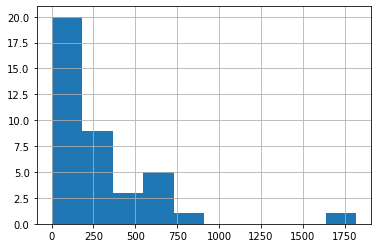

In [212]:
max_rows.hr_score.value_counts().hist()

In [109]:
pd.set_option('display.max_rows', 30, 'display.max_columns', None)

In [110]:
np.logical_or(max_rows.hr_he_heading_alligned, max_rows.hr_le_heading_alligned).value_counts()

False    7480
True     6114
dtype: int64

In [199]:
max_rows.track_id.value_counts().reset_index()

index  track_id
0       896558_ABY321_0         6
1        3ff66e_DMYIC_0         5
2       4baad9_THY3PE_0         4
3       4bab2f_THY3DJ_0         4
4             4bb066__0         4
...                 ...       ...
10019         392af8__0         1
10020  393320_AFR78RT_0         1
10021  393323_AFR42JM_0         1
10022  3944e5_AFR78GH_0         1
10023  e8021a_LCO1504_0         1

[10024 rows x 2 columns]

In [49]:
heuristics_pdf[heuristics_pdf['hr_he_score'] == heuristics_pdf['hr_le_score']].to_excel('test.xlsx')

In [50]:
heuristics_pdf[heuristics_pdf['hr_he_score'] == heuristics_pdf['hr_le_score']]

track_id  icao24 flight_id airport_ident le_ident  \
64            4ca244__0  4ca244                    EBCI       06   
91     4ca2d4_RYR96BW_0  4ca2d4  RYR96BW           EIDW       16   
183           152027__0  152027                    UUEE      06C   
338     4b161a_SWR7UF_0  4b161a  SWR7UF            LSZH       10   
405     4cc516_ICE51R_0  4cc516  ICE51R            BIRK       13   
...                 ...     ...       ...           ...      ...   
23650   4d21a2_AMC309_0  4d21a2  AMC309            LMML       05   
23662    407844_SHT7A_0  407844  SHT7A             EGPF       09   
23671    4ca98d_EIICA_0  4ca98d  EIICA             EIDW      10L   
23685    49d05c_OKDSY_0  49d05c  OKDSY             LKPR       06   
23719   486483_KLM66Q_0  486483  KLM66Q            EHAM      18L   

       le_heading_deg he_ident  he_heading_deg hex_le_time_entry_min  \
64          66.000000       24      246.000000                   NaT   
91         157.000000       34      337.000000                   NaT   
183         64.000000      24C      244.000000                   NaT   
338         96.000000       28      276.000000   2023-01-02 18:59:05   
405        117.000000       31      297.000000                   NaT   
...               ...      ...             ...                   ...   
23650       56.000000       23      236.000000                   NaT   
23662       90.599998       27      270.600006                   NaT   
23671       97.000000      28R      278.000000                   NaT   
23685       65.000000       24      245.000000                   NaT   
23719      183.000000      36R        3.000000                   NaT   

       hex_le_flight_level_min  ...  hr_he_score hr_le_score  hr_he_le  \
64                         NaN  ...    19.512195   19.512195        le   
91                         NaN  ...    19.512195   19.512195        le   
183                        NaN  ...    19.512195   19.512195        le   
338                       10.0  ...    23.902439   23.902439        le   
405                        NaN  ...    19.512195   19.512195        le   
...                        ...  ...          ...         ...       ...   
23650                      NaN  ...    19.512195   19.512195        le   
23662                      NaN  ...    19.512195   19.512195        le   
23671                      NaN  ...    19.512195   19.512195        le   
23685                      NaN  ...    19.512195   19.512195        le   
23719                      NaN  ...    19.512195   19.512195        le   

       hr_he_gt_le   he_or_le   hr_score  hr_rwy  \
64           False  26.666667  19.512195      06   
91           False  26.666667  19.512195      16   
183          False  26.666667  19.512195     06C   
338          False  36.000000  23.902439      10   
405          False  26.666667  19.512195      13   
...            ...        ...        ...     ...   
23650        False  26.666667  19.512195      05   
23662        False  26.666667  19.512195      09   
23671        False  26.666667  19.512195     10L   
23685        False  26.666667  19.512195      06   
23719        False  26.666667  19.512195     18L   

      hr_he_heading_alligned_on_rwy  hr_le_heading_alligned_on_rwy  \
64                            False                          False   
91                            False                          False   
183                           False                          False   
338                           False                          False   
405                           False                          False   
...                             ...                            ...   
23650                         False                          False   
23662                         False                          False   
23671                         False                          False   
23685                         False                          False   
23719                         False              

In [51]:
heuristics_pdf[heuristics_pdf.track_id=='4d2273_RYR2AR_0']

track_id  icao24 flight_id airport_ident le_ident  \
313   4d2273_RYR2AR_0  4d2273  RYR2AR            LIRU       16   
5655  4d2273_RYR2AR_0  4d2273  RYR2AR            LIRA       15   

      le_heading_deg he_ident  he_heading_deg hex_le_time_entry_min  \
313            160.0       34           340.0   2023-01-05 20:59:55   
5655           152.0       33           332.0                   NaT   

      hex_le_flight_level_min  ...  hr_he_score hr_le_score  hr_he_le  \
313                      23.0  ...    11.707317   21.463415        le   
5655                      NaN  ...     5.853659    0.000000        he   

      hr_he_gt_le  he_or_le   hr_score  hr_rwy hr_he_heading_alligned_on_rwy  \
313         False      16.0  21.463415      16                         False   
5655         True       8.0   5.853659      33                         False   

      hr_le_heading_alligned_on_rwy  hr_rwy_ident  
313                           False            16  
5655                          False            33  

[2 rows x 60 columns]

In [112]:
heuristics_pdf.to_excel('test.xlsx')

In [110]:
hr_rwy_detection_weight/max_score

0.32

In [19]:
heuristics_pdf.hex_le_intersected_subsections.value_counts(dropna=False).sum()

19922

array([[<AxesSubplot: title={'center': 'airport_ident'}>]], dtype=object)

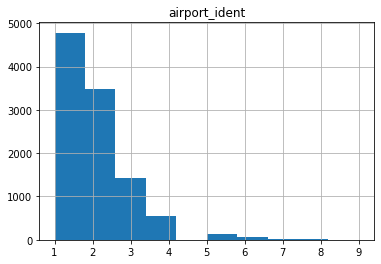

In [23]:
heuristics_pdf.groupby('track_id')['airport_ident'].count().reset_index().hist()

In [ ]:
heuristics_pdf.groupby('track_id')['airport_ident'].count().reset_index().sort_values

In [14]:
heuristics_pdf

AttributeError: 'DataFrame' object has no attribute 'gate_type'

In [21]:
cols_to_group = [
    "track_id", "icao24", "flight_id", 
    "airport_ident", "le_ident", "le_heading_deg", 
    "he_ident", "he_heading_deg", "min_gate_distance", 
    "max_gate_distance", , "intersected_subsections"]

min_dist_pdf['flight_id'] = min_dist_pdf.flight_id.fillna('')
min_dist_pdf = min_dist_pdf.groupby(cols_to_group).agg({
    'event_time': 'min',  # Taking the minimum of event_time
    'flight_level': 'min',  # Taking the minimum of flight_level
    'heading': 'median'  # Taking the median of heading
}).reset_index()

min_dist_pdf = min_dist_pdf.rename({
    'event_time':'time_entry_min_gate_distance',
    'flight_level': 'flight_lvl_min_gate_distance',
    'heading' : 'heading_min_gate_distance'
},axis=1)

max_dist_pdf['flight_id'] = max_dist_pdf.flight_id.fillna('')
max_dist_pdf = max_dist_pdf.groupby(cols_to_group).agg({
    'event_time': 'min',  # Taking the minimum of event_time
    'flight_level': 'min',  # Taking the minimum of flight_level
    'heading': 'median'  # Taking the median of heading
}).reset_index()

max_dist_pdf = max_dist_pdf.rename({
    'event_time':'time_entry_max_gate_distance', 
    'flight_level': 'flight_lvl_max_gate_distance',
    'heading' : 'heading_max_gate_distance'},axis=1)

KeyError: "Column(s) ['event_time', 'flight_level', 'heading'] do not exist"

In [18]:
dist_pdf = min_dist_pdf.merge(max_dist_pdf, on = cols_to_group, how = 'outer')

In [15]:
dist_pdf

NameError: name 'dist_pdf' is not defined

In [20]:
max_dist_approach_pdf

NameError: name 'max_dist_approach_pdf' is not defined

In [ ]:
df.groupby(['track_id', 'airport_ident'])

In [ ]:
pd = sv_on_rwy_cp.toPandas()

In [ ]:
pd

In [ ]:
pd.groupby(["track_id",  "airport_ident", "le_ident", "he_ident"]).

In [1]:
pd

NameError: name 'pd' is not defined

In [16]:
pd.columns

Index(['track_id', 'icao24', 'flight_id', 'event_time', 'lat', 'lon',
       'flight_level', 'heading', 'vert_rate', 'on_ground', 'h3_res_6',
       'h3_res_11', 'apt_hex_id', 'apt_ident', 'airport_ident', 'le_ident',
       'le_heading_deg', 'he_ident', 'he_heading_deg', 'hex_id', 'gate_id',
       'gate_id_nr', 'gate_type', 'gate_distance_from_rwy_nm',
       'min_gate_distance', 'max_gate_distance'],
      dtype='object')

In [14]:
# Merge the min and max values into the original DataFrame
sv_on_rwy_cp = sv_on_rwy_cp.join(min_values.select("track_id", "apt_ident", "le_ident", "he_ident", "min_gate_distance"), ["track_id", "apt_ident", "le_ident", "he_ident"], "left")
sv_on_rwy_cp = sv_on_rwy_cp.join(max_values.select("track_id", "apt_ident", "le_ident", "he_ident", "max_gate_distance"), ["track_id", "apt_ident", "le_ident", "he_ident"], "left")


In [13]:

# Filter rows where 'gate_distance_from_rwy_nm' matches the min or max values
result_min = sv_on_rwy_cp.filter(sv_on_rwy_cp['gate_distance_from_rwy_nm'] == sv_on_rwy_cp['min_gate_distance'])
result_max = sv_on_rwy_cp.filter(sv_on_rwy_cp['gate_distance_from_rwy_nm'] == sv_on_rwy_cp['max_gate_distance'])

# Selecting and renaming columns
cols_of_interest = ["track_id", "apt_ident", "le_ident", "he_ident", "min_gate_distance", "max_gate_distance"]
result_min = result_min.select(*cols_of_interest)
result_max = result_max.select(*cols_of_interest)

# Merge the min and max DataFrames
det = result_min.join(result_max, ["track_id", "apt_ident", "le_ident", "he_ident"], "outer")


In [ ]:
det_pd = det.toPandas()

In [ ]:
det_pd

In [ ]:

# Adding and computing additional columns
det = det.withColumn("time_since_minimum_distance_s", (F.col("min_gate_distance") - F.col("max_gate_distance")) * 1000)  # Assuming time columns are in seconds

# Adding status based on time since minimum distance
det = det.withColumn("status", F.when(F.col("time_since_minimum_distance_s") > 0, "arrival").otherwise("departure"))

# Final selection of columns
det_final = det.select("track_id", "apt_ident", "le_ident", "he_ident", "status")

# Additional aggregations as per the original requirement
gb_cols = ["track_id", "apt_ident", "le_ident", "he_ident", "gate_type"]
result_agg = sv_on_rwy.groupBy(gb_cols).agg(
    F.min("min").alias("entry_time_approach_area"),
    F.max("max").alias("exit_time_approach_area"),
    F.count("gate_distance_from_rwy_nm").alias("intersected_subsections"),
    F.min("gate_distance_from_rwy_nm").alias("minimal_distance_runway"),
    F.max("gate_distance_from_rwy_nm").alias("maximal_distance_runway")
).reset_index()


AnalysisException: Reference 'min_gate_distance' is ambiguous, could be: min_gate_distance, min_gate_distance.

In [ ]:
rs = result_agg.toPandas()

In [16]:
test[['track_id', 'event_time', 'time_diff']]

track_id          event_time  time_diff
0               01010a_0 2023-01-06 01:55:50        NaN
1      0101b6_MSR714  _0 2023-01-07 02:44:55        NaN
2      0101b6_MSR714  _0 2023-01-07 02:45:00        5.0
3      0101b6_MSR714  _0 2023-01-07 02:45:05        5.0
4      0101b6_MSR714  _0 2023-01-07 02:45:05        0.0
...                  ...                 ...        ...
73463  acbeab_FDX6257 _0 2023-01-04 03:42:35        0.0
73464  acbeab_FDX6257 _0 2023-01-04 03:42:40        5.0
73465  acbeab_FDX6257 _0 2023-01-04 03:42:40        0.0
73466  acbeab_FDX6257 _0 2023-01-04 03:42:45        5.0
73467  acbeab_FDX6257 _0 2023-01-04 03:42:45        0.0

[73468 rows x 3 columns]

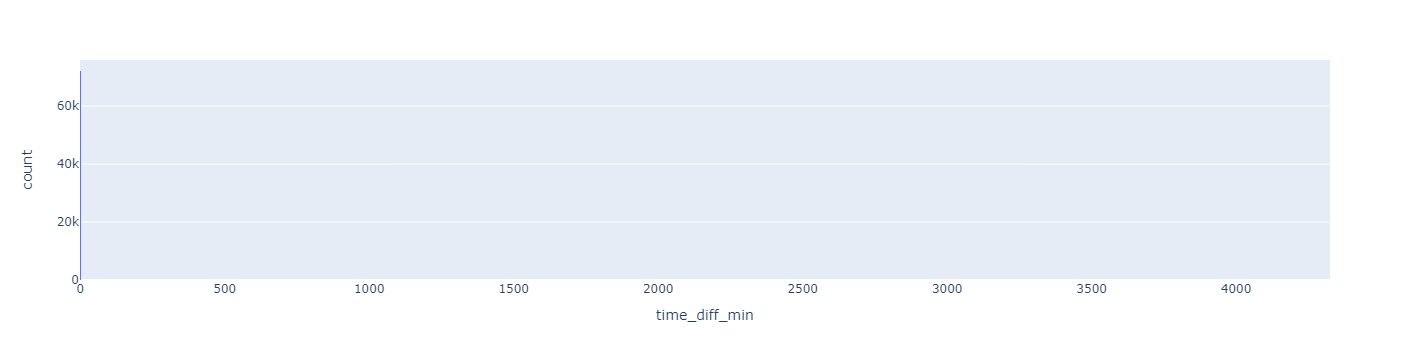

In [20]:
import plotly.express as px

test['time_diff_min'] = test.time_diff/60
px.histogram(test,x='time_diff_min', nbins = 3000)

In [41]:
tmp = test[np.logical_and(test.icao24.str.strip() == '4ca4f4', test.flight_id.str.strip() == 'RYR1BU')]

In [60]:
tmp = test[test.track_id== 'ae01cd_JAKE11  _0']

In [61]:
tmp

track_id  icao24 flight_id          event_time        lat  \
67269  ae01cd_JAKE11  _0  ae01cd  JAKE11   2023-01-04 17:40:45  52.369871   
67270  ae01cd_JAKE11  _0  ae01cd  JAKE11   2023-01-04 17:40:50  52.365509   
67271  ae01cd_JAKE11  _0  ae01cd  JAKE11   2023-01-04 17:40:55  52.360933   
67272  ae01cd_JAKE11  _0  ae01cd  JAKE11   2023-01-04 17:41:00  52.356674   
67273  ae01cd_JAKE11  _0  ae01cd  JAKE11   2023-01-04 17:41:05  52.352740   
...                  ...     ...       ...                 ...        ...   
67349  ae01cd_JAKE11  _0  ae01cd  JAKE11   2023-01-04 17:50:05  52.359676   
67350  ae01cd_JAKE11  _0  ae01cd  JAKE11   2023-01-04 17:50:10  52.360607   
67351  ae01cd_JAKE11  _0  ae01cd  JAKE11   2023-01-04 17:50:15  52.361389   
67352  ae01cd_JAKE11  _0  ae01cd  JAKE11   2023-01-04 17:50:20  52.361389   
67353  ae01cd_JAKE11  _0  ae01cd  JAKE11   2023-01-04 17:50:25  52.362190   

            lon  flight_level     heading  vert_rate  on_ground  ...  \
67269  1.039307            27  197.014683   -3.57632      False  ...   
67270  1.037140            27  196.642091   -4.87680      False  ...   
67271  1.034912            26  196.642091   -3.90144      False  ...   
67272  1.032867            26  196.440380   -0.97536      False  ...   
67273  1.030988            26  195.736135    0.00000      False  ...   
...         ...           ...         ...        ...        ...  ...   
67349  0.501918             0  283.172553   -2.60096      False  ...   
67350  0.495719             0  283.528315    0.65024      False  ...   
67351  0.490494             0  283.313632    0.65024      False  ...   
67352  0.490494             0  283.313632    0.65024      False  ...   
67353  0.484732             0  283.270644    0.97536      False  ...   

      airport_ident le_ident le_heading_deg he_ident he_heading_deg  \
67269          EGXH       09           81.0       27          261.0   
67270          EGXH       09           81.0       27          261.0   
67271          EGXH       09           81.0       27          261.0   
67272          EGXH       09           81.0       27          261.0   
67273          EGXH       09           81.0       27          261.0   
...             ...      ...            ...      ...            ...   
67349          EGUN       10          103.0       28          283.0   
67350          EGUN       10          103.0       28          283.0   
67351          EGUN       10          103.0       28          283.0   
67352          EGUN       10          103.0       28          283.0   
67353          EGUN       10          103.0       28          283.0   

                hex_id                               gate_id gate_id_nr  \
67269  8b194166b492fff  low_numbered_approach_hexagons_10_nm      10000   
67270  8b194164ca36fff  low_numbered_approach_hexagons_10_nm      10000   
67271  8b194164cadefff  low_numbered_approach_hexagons_10_nm      10000   
67272  8b194164c246fff  low_numbered_approach_hexagons_10_nm      10000   
67273  8b194164d59dfff  low_numbered_approach_hexagons_10_nm      10000   
...                ...                                   ...        ...   
67349  8b194ed1dd33fff                       runway_hexagons      20000   
67350  8b194ed1caccfff                       runway_hexagons      20000   
67351  8b194ed1c304fff                       runway_hexagons      20000   
67352  8b194ed1c304fff                       runway_hexagons      20000   
67353  8b194ed1c3b0fff                       runway_hexagons      20000   

                            gate_type gate_distance_from_rwy_nm  
67269  low_numbered_approach_hexagons                        10  
67270  low_numbered_approach_hexagons                        10  
67271  low_numbered_approach_hexagons                        10  
67272  low_numbered_approach_hexagons                        10  
67273  low_numbered_approach_hexagons                        10  
...                               ...                       ...  
67349     

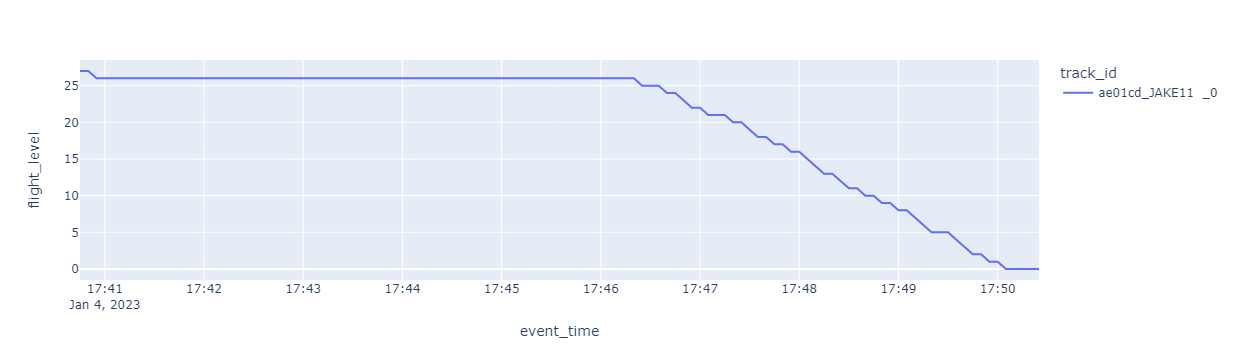

In [62]:
px.line(tmp, x='event_time', y = 'flight_level', color = 'track_id')

In [29]:
test[test.track_id.str.split('_').apply(lambda l:l[-1])=='1']

track_id  icao24 flight_id          event_time        lat  \
635    3415ce_IBE30LT _1  3415ce  IBE30LT  2023-01-04 17:53:00  41.365620   
636    3415ce_IBE30LT _1  3415ce  IBE30LT  2023-01-04 17:53:00  41.365620   
637    3415ce_IBE30LT _1  3415ce  IBE30LT  2023-01-04 17:53:05  41.363944   
638    3415ce_IBE30LT _1  3415ce  IBE30LT  2023-01-04 17:53:05  41.363944   
639    3415ce_IBE30LT _1  3415ce  IBE30LT  2023-01-04 17:53:10  41.362175   
...                  ...     ...       ...                 ...        ...   
63989  4ca4f4_RYR1BU  _1  4ca4f4  RYR1BU   2023-01-04 17:58:50  51.159140   
63990  4ca4f4_RYR1BU  _1  4ca4f4  RYR1BU   2023-01-04 17:58:55  51.159140   
63991  4ca4f4_RYR1BU  _1  4ca4f4  RYR1BU   2023-01-04 17:58:55  51.159140   
63992  4ca4f4_RYR1BU  _1  4ca4f4  RYR1BU   2023-01-04 17:59:00  51.159140   
63993  4ca4f4_RYR1BU  _1  4ca4f4  RYR1BU   2023-01-04 17:59:00  51.159140   

            lon  flight_level     heading  vert_rate  on_ground  ...  \
635    2.279289            18  246.068975   -0.32512      False  ...   
636    2.279289            18  246.068975   -0.32512      False  ...   
637    2.274357            18  245.942651    0.00000      False  ...   
638    2.274357            18  245.942651    0.00000      False  ...   
639    2.268989            18  245.942651    0.00000      False  ...   
...         ...           ...         ...        ...        ...  ...   
63989 -0.110168             9  258.088785   -3.57632      False  ...   
63990 -0.110168             9  258.088785   -3.57632      False  ...   
63991 -0.110168             9  258.088785   -3.57632      False  ...   
63992 -0.110168             9  258.088785   -3.57632      False  ...   
63993 -0.110168             9  258.088785   -3.57632      False  ...   

      airport_ident le_ident le_heading_deg he_ident he_heading_deg  \
635            LEBL      06L           66.0      24R          246.0   
636            LEBL      06R           66.0      24L          246.0   
637            LEBL      06L           66.0      24R          246.0   
638            LEBL      06R           66.0      24L          246.0   
639            LEBL      06L           66.0      24R          246.0   
...             ...      ...            ...      ...            ...   
63989          EGKK      08R           78.0      26L          258.0   
63990          EGKK      08L           78.0      26R          258.0   
63991          EGKK      08R           78.0      26L          258.0   
63992          EGKK      08L           78.0      26R          258.0   
63993          EGKK      08R           78.0      26L          258.0   

                hex_id                               gate_id gate_id_nr  \
635    8b394465238efff  low_numbered_approach_hexagons_10_nm      10000   
636    8b394465238efff  low_numbered_approach_hexagons_10_nm      10000   
637    8b394465272dfff  low_numbered_approach_hexagons_10_nm      10000   
638    8b394465272dfff  low_numbered_approach_hexagons_10_nm      10000   
639    8b3944652445fff  low_numbered_approach_hexagons_10_nm      10000   
...                ...                                   ...        ...   
63989  8b194ace90b3fff   low_numbered_approach_hexagons_4_nm      14000   
63990  8b194ace90b3fff   low_numbered_approach_hexagons_4_nm      14000   
63991  8b194ace90b3fff   low_numbered_approach_hexagons_4_nm      14000   
63992  8b194ace90b3fff   low_numbered_approach_hexagons_4_nm      14000   
63993  8b194ace90b3fff   low_numbered_approach_hexagons_4_nm      14000   

                            gate_type gate_distance_from_rwy_nm  
635    low_numbered_approach_hexagons                        10  
636    low_numbered_approach_hexagons                        10  
637    low_numbered_approach_hexagons                        10  
638    low_numbered_approach_hexagons                        10  
639    low_numbered_approach_hexagons                        10  
...                               ...                       ...  
63989  low

In [14]:
test.gate_type.value_counts()

low_numbered_approach_hexagons     28091
high_numbered_approach_hexagons    14158
runway_hexagons                     3408
Name: gate_type, dtype: int64

In [ ]:
5/60

0.08333333333333333

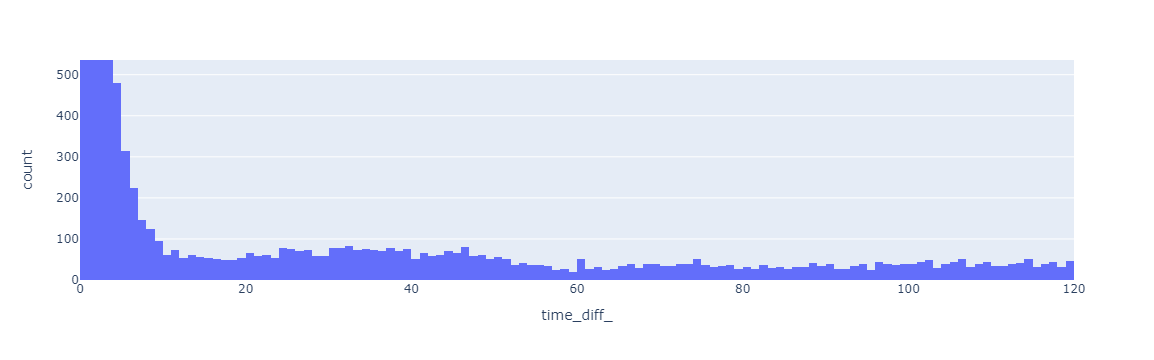

In [ ]:
import plotly.express as px
tmp['time_diff_'] = tmp['time_diff']/60

tmp_ = tmp[tmp['time_diff_'] > 5/60]
tmp_ = tmp_[tmp_['time_diff_'] < 120]
px.histogram(tmp_, x='time_diff_')

In [97]:
tmp.sort_values(['track_id','event_time'])

track_id  icao24 flight_id          event_time        lat  \
11001           0100dd  0100dd      None 2023-01-07 11:20:15  36.787021   
18359           0100dd  0100dd      None 2023-01-07 11:20:20  36.786602   
18360           0100dd  0100dd      None 2023-01-07 11:20:25  36.786602   
18361           0100dd  0100dd      None 2023-01-07 11:20:30  36.786602   
18362           0100dd  0100dd      None 2023-01-07 11:20:35  36.786602   
...                ...     ...       ...                 ...        ...   
37553  e48ced_PPCFJ     e48ced  PPCFJ    2023-01-07 11:02:05  41.793137   
22877  e48ced_PPCFJ     e48ced  PPCFJ    2023-01-07 11:02:10  41.788035   
26619  e48ced_PPCFJ     e48ced  PPCFJ    2023-01-07 11:02:15  41.786034   
4623   e48ced_PPCFJ     e48ced  PPCFJ    2023-01-07 11:02:20  41.783985   
1206   e48ced_PPCFJ     e48ced  PPCFJ    2023-01-07 11:02:25  41.777608   

             lon  flight_level     heading  vert_rate  on_ground  ...  \
11001   3.385834            19  263.589160   -3.90144      False  ...   
18359   3.384140            19  263.589160   -3.90144      False  ...   
18360   3.384140            19  263.589160   -3.90144      False  ...   
18361   3.384140            19  263.589160   -3.90144      False  ...   
18362   3.384140            19  263.589160   -3.90144      False  ...   
...          ...           ...         ...        ...        ...  ...   
37553  12.598884             5  156.236178   18.53184      False  ...   
22877  12.601957            10  155.170653   18.85696      False  ...   
26619  12.603171            12  154.425555   13.65504      False  ...   
4623   12.604512            14  160.676816   13.32992      False  ...   
1206   12.606875            18  175.548826   16.58112      False  ...   

            apt_hex_id                 apt_ident airport_ident le_ident  \
11001  86395a797ffffff                    [DAAG]          DAAG       05   
18359  86395a797ffffff                    [DAAG]          DAAG       05   
18360  86395a797ffffff                    [DAAG]          DAAG       05   
18361  86395a797ffffff                    [DAAG]          DAAG       05   
18362  86395a797ffffff                    [DAAG]          DAAG       05   
...                ...                       ...           ...      ...   
37553  861e8042fffffff  [LIRA, LIRE, LIRG, LIRU]          LIRA       15   
22877  861e8042fffffff  [LIRA, LIRE, LIRG, LIRU]          LIRA       15   
26619  861e8042fffffff  [LIRA, LIRE, LIRG, LIRU]          LIRA       15   
4623   861e8042fffffff  [LIRA, LIRE, LIRG, LIRU]          LIRA       15   
1206   861e8042fffffff  [LIRA, LIRE, LIRG, LIRU]          LIRA       15   

      le_heading_deg he_ident  he_heading_deg           hex_id  \
11001           53.0       23           233.0  8b395a795309fff   
18359           53.0       23           233.0  8b395a795303fff   
18360           53.0       23           233.0  8b395a795303fff   
18361           53.0       23           233.0  8b395a795303fff   
18362           53.0       23           233.0  8b395a795303fff   
...              ...      ...             ...              ...   
37553          152.0       33           332.0  8b1e8042e331fff   
22877          152.0       33           332.0  8b1e8042e2a9fff   
26619          152.0       33           332.0  8b1e8042e2d2fff   
4623           152.0       33           332.0  8b1e8042a90bfff   
1206           152.0       33           332.0  8b1e8042a12dfff   

                                   gate_id gate_id_nr  
11001  low_numbered_approach_hexagons_9_nm      19000  
18359  low_numbered_approach_hexagons_9_nm      19000  
18360  low_numbered_approach_hexagons_9_nm      19000  
18361  low_numbered_approach_hexagons_9_nm      19000  
18362  low_numbered_approach_hexagons_9_nm      19000  
...                                    ...        ...  
37553                      runway_hexagons      20000  
22877  low_numbered_approach_hexagons_1_nm      11000  
26619  low_numbered_approach_hexagons_

In [55]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Assuming arr_dep_apt is your Spark DataFrame and 'track_id_col' is defined

# Step 1: Initialize the 'segment_status' column with an empty string
arr_dep_apt = arr_dep_apt.withColumn('segment_status', F.lit(''))

# Step 2: Create a window specification partitioned by 'track_id_col' and 'ident'
track_id_col = 'track_id_tmp'
windowSpec = Window.partitionBy(track_id_col, 'apt_ident')

# Finding the min and max time for each group
min_time = F.min('event_time').over(windowSpec)
max_time = F.max('event_time').over(windowSpec)

# Step 3: Mark the 'start' and 'end' based on the min and max times
arr_dep_apt = arr_dep_apt.withColumn('segment_status', 
                                     F.when(F.col('event_time') == min_time, 'start')
                                     .when(F.col('event_time') == max_time, 'end')
                                     .otherwise(F.col('segment_status')))

# Step 4: Filter to only include 'start' or 'end'
filtered_df = arr_dep_apt.filter(F.col('segment_status').isin(['start', 'end']))


In [56]:
tmp = filtered_df.toPandas()

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:194: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


In [58]:
tmp.columns

Index(['event_time', 'icao24', 'lat', 'lon', 'velocity', 'heading',
       'vert_rate', 'callsign', 'on_ground', 'alert', 'spi', 'squawk',
       'baro_altitude', 'geo_altitude', 'last_pos_update', 'last_contact',
       'serials', 'h3_res_12', 'h3_res_11', 'h3_res_10', 'h3_res_9',
       'h3_res_8', 'h3_res_7', 'h3_res_6', 'h3_res_5', 'h3_res_4', 'h3_res_3',
       'h3_res_2', 'h3_res_1', 'h3_res_0', 'baroaltitude_ft',
       'baroaltitude_fl', 'low_alt', 'apt_hex_id', 'apt_ident', 'track_id_tmp',
       'segment_status'],
      dtype='object')

### Main runway merge

In [11]:
from pyspark.sql.functions import collect_list

In [12]:
rwy_sdf_dedup = rwy_sdf.groupBy("hex_id", "hex_res", "hex_lon", "hex_lat").agg(
    collect_list("airport_ident").alias("airport_ident_list"),
    collect_list("le_ident").alias("le_ident_list"),
    collect_list("le_heading_deg").alias("le_heading_deg_list"),
    collect_list("he_ident").alias("he_ident_list"),
    collect_list("he_heading_deg").alias("he_heading_deg_list"),
    collect_list("gate_id").alias("gate_id_list"),
    collect_list("gate_id_nr").alias("gate_id_nr_list")
)

In [24]:
df = sdf_fi.toPandas()

In [30]:
tmp = df[~df['gate_id_list'].isna()]

In [35]:
tmp.id.value_counts()

440614_EJU74QN     101
4cad3f_RYR56JP      96
40624f_SHT9Y        84
40600d_EZY36BN      65
45ac37_SAS688       49
48414c_TRA16E       47
392af8_AFR14DF      45
4b1a29_EZS18TE      37
393323_AFR36TM      31
4010ee_EZY87RE      29
4d012c_CLX9874      29
71005b_SVA9062      17
Name: id, dtype: int64

In [38]:
tmp[tmp.id.str.contains('440614_EJU74QN')].sort_values('event_time')

event_time  icao24        lat       lon   velocity     heading  \
1513  1672951360  440614  44.942089 -0.552934  95.309689  225.437364   
2354  1672951365  440614  44.938225 -0.558494  94.582177  225.440728   
3749  1672951370  440614  44.934967 -0.563183  93.863124  225.888235   
4456  1672951375  440614  44.931754 -0.567806  92.766964  225.674037   
4457  1672951380  440614  44.928772 -0.572074  91.311999  225.684778   
...          ...     ...        ...       ...        ...         ...   
1146  1672951840  440614  44.842560 -0.695421  68.025372  225.306392   
1147  1672951845  440614  44.842560 -0.695421  68.025372  225.306392   
1148  1672951850  440614  44.842560 -0.695421  68.025372  225.306392   
1149  1672951855  440614  44.842560 -0.695421  68.025372  225.306392   
1150  1672951860  440614  44.842560 -0.695421  68.025372  225.306392   

      vert_rate  callsign  on_ground  alert  ...   hex_lon    hex_lat  \
1513   -2.60096  EJU74QN       False  False  ... -0.552861  44.941940   
2354   -5.20192  EJU74QN       False  False  ... -0.558716  44.938240   
3749   -5.20192  EJU74QN       False  False  ... -0.563169  44.935062   
4456   -5.20192  EJU74QN       False  False  ... -0.567622  44.931885   
4457   -5.52704  EJU74QN       False  False  ... -0.572074  44.928707   
...         ...       ...        ...    ...  ...       ...        ...   
1146   -3.90144  EJU74QN       False  False  ... -0.695178  44.842491   
1147   -3.90144  EJU74QN       False  False  ... -0.695178  44.842491   
1148   -3.90144  EJU74QN       False  False  ... -0.695178  44.842491   
1149   -3.90144  EJU74QN       False  False  ... -0.695178  44.842491   
1150   -3.90144  EJU74QN       False  False  ... -0.695178  44.842491   

      airport_ident_list  le_ident_list  le_heading_deg_list  he_ident_list  \
1513              [LFBD]           [05]               [46.0]           [23]   
2354              [LFBD]           [05]               [46.0]           [23]   
3749              [LFBD]           [05]               [46.0]           [23]   
4456              [LFBD]           [05]               [46.0]           [23]   
4457              [LFBD]           [05]               [46.0]           [23]   
...                  ...            ...                  ...            ...   
1146              [LFBD]           [05]               [46.0]           [23]   
1147              [LFBD]           [05]               [46.0]           [23]   
1148              [LFBD]           [05]               [46.0]           [23]   
1149              [LFBD]           [05]               [46.0]           [23]   
1150              [LFBD]           [05]               [46.0]           [23]   

     he_heading_deg_list                            gate_id_list  \
1513             [226.0]  [low_numbered_approach_hexagons_10_nm]   
2354             [226.0]  [low_numbered_approach_hexagons_10_nm]   
3749             [226.0]  [low_numbered_approach_hexagons_10_nm]   
4456             [226.0]   [low_numbered_approach_hexagons_9_nm]   
4457             [226.0]   [low_numbered_approach_hexagons_9_nm]   
...                  ...                                     ...   
1146             [226.0]   [low_numbered_approach_hexagons_2_nm]   
1147             [226.0]   [low_numbered_approach_hexagons_2_nm]   
1148             [226.0]   [low_numbered_approach_hexagons_2_nm]   
1149             [226.0]   [low_numbered_approach_hexagons_2_nm]   
1150             [226.0]   [low_numbered_approach_hexagons_2_nm]   

     gate_id_nr_list               id  
1513         [10000]  440614_EJU74QN   
2354         [10000]  440614_EJU74QN   
3749         [10000]  440614_EJU74QN   
4456         [19000]  440614_EJU74QN   
4457         [19000]  440614_EJU74QN   
...              ...              ...  
1146         [12000]  440614_EJU74QN   
1147         [12000]  440614_EJU74QN   
1148         [12000]  440614_EJU74QN   
1149         [12000]  440614_EJU74QN   
1150         [12000]  440614_EJU74QN   

[101 rows x 47 co

In [28]:
df['id'].value_counts()

KeyError: 'id'

In [15]:
df[df.baro_altitude.isna()]

Empty DataFrame
Columns: [event_time, icao24, lat, lon, velocity, heading, vert_rate, callsign, on_ground, alert, spi, squawk, baro_altitude, geo_altitude, last_pos_update, last_contact, serials, h3_res_12, h3_res_11, h3_res_10, h3_res_9, h3_res_8, h3_res_7, h3_res_6, h3_res_5, h3_res_4, h3_res_3, h3_res_2, h3_res_1, h3_res_0, baroaltitude_ft, baroaltitude_fl, low_alt, apt_hex_id, apt_ident, hex_id, hex_res, hex_lon, hex_lat, airport_ident_list, le_ident_list, le_heading_deg_list, he_ident_list, he_heading_deg_list, gate_id_list, gate_id_nr_list]
Index: []

[0 rows x 46 columns]